# Negative and nonlinear coabundances through Pearson correlation

In [10]:
net_folder = '/root/host_home/luca/outputARACNE/'
meta_folder = '/root/host_home/luca/metadata/'
nb_dir = '/root/host_home/luca/nb_graphAnalysis/'
cell_type_key = 'cell_type_adjusted'
sample_key = 'sample'

In [11]:
import os
os.chdir(nb_dir)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr

import networkx as nx

In [193]:
# Draw G
from matplotlib.colors import LogNorm


def draw_graph(G, ax, title):
    pos = nx.spring_layout(G, seed=0)  # Set the position of the nodes
    nx.draw(G, pos, with_labels=True, node_size=170, font_size=8, font_family="sans-serif", edge_color='black', ax=ax)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=5, ax=ax)
    ax.set_title(title)
    ax.axis('off')  # Turn off the axis
    

def plot_corr_networks(time, corr_threshold=0.3, p_threshold=0.05):
    """
    corr_types_plus1: counts of samples with cell types + 1
    corr_types: normalized counts of samples with cell types
    corr_plus1_norm: normalized counts of samples with cell types + 1
    """
    time_solo = time.split('_')[0]
    # Unstack the group counts
    groups = pd.read_csv(f'{meta_folder}/groups_{time_solo}_zuani.csv', index_col=0)
    groups.sort_values([cell_type_key, sample_key])
    groups.set_index([cell_type_key,sample_key], inplace=True)
    cutoff = groups.loc[:, '0']
    samp_type = cutoff.unstack().transpose()

    # Normalize the counts
    samp_type = samp_type.fillna(0)

    corr_types = (samp_type.T / samp_type.T.sum()).T
    corr_types.reset_index(inplace=True)
    corr_types.index = corr_types[sample_key]
    del corr_types[sample_key]
    print(f'Size of Corr_types: {corr_types.shape}')


    # create a matrix of all the zero entires vefore losing that information
    corr_types_plus1 = samp_type + 1
    corr_types_plus1.reset_index(inplace=True)
    corr_types_plus1.index = corr_types_plus1[sample_key]
    del corr_types_plus1[sample_key]
    corr_plus1_norm = (corr_types_plus1.T / corr_types_plus1.T.sum()).T
    print(f'Size of Corr_types +1: {corr_types_plus1.shape}')

    # Compute pairwise correlations and p-values
    data = corr_types.to_numpy().T

    # We save the datsetinfo to corr_types for later use in plots
    groups.reset_index(inplace=True)
    group_dataset = groups.groupby(['sample','dataset']).sum()
    group_dataset.reset_index(inplace=True)
    corr_types = pd.merge(corr_types, group_dataset.loc[:,[sample_key,'dataset']], how='left', left_index=True, right_on=sample_key)
    corr_types_plus1 = pd.merge(corr_types_plus1, group_dataset.loc[:,[sample_key,'dataset']], how='left', left_index=True, right_on=sample_key)
    corr_plus1_norm = pd.merge(corr_plus1_norm, group_dataset.loc[:,[sample_key,'dataset']], how='left', left_index=True, right_on=sample_key)

    print(f'Size of Corr_types +1: {corr_types_plus1.shape}')


    # Merge samp_type with 'dataset' information
    samp_type_with_dataset = pd.merge(samp_type, group_dataset.loc[:,[sample_key,'dataset']], how='left', on=sample_key)
    # Compute counts of zeros per cell type per dataset
    zeros_per_dataset = samp_type_with_dataset.groupby('dataset').apply(lambda x: (x.drop(['dataset',sample_key], axis=1) != 0).sum())
    # Transpose for plotting
    zeros_per_dataset_T = zeros_per_dataset.T
    # Plot stacked bar chart
    ax = zeros_per_dataset_T.plot(kind='bar', stacked=True, figsize=(14, 9))

    ax.set_ylabel('# 0 samples')
    ax.set_title('# Samples with no Cell Type')
    ax.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=90)
    plt.savefig(f'{nb_dir}/output/0_samples_{time}.png', bbox_inches='tight')
    plt.close()

    # Initialize matrices for correlation coefficients and p-values
    n_variables = data.shape[0]  # Number of variables, eg. cell types``
    pearson_matrix = np.zeros((n_variables, n_variables))
    pearson_p_values = np.zeros((n_variables, n_variables))

    for i in range(n_variables):
        for j in range(n_variables):
            if i == j:
                # The correlation of a variable with itself is always 1, and the p-value is 0
                pearson_matrix[i, j] = 1
                pearson_p_values[i, j] = 0
            elif i < j:
                # Compute correlation and p-value for unique pairs only
                correlation, p_value = pearsonr(data[i], data[j])
                if np.isnan(correlation):
                    print(f'Correlation between {corr_types.columns[i]} and {corr_types.columns[j]} is NaN')
                    correlation = 0
                    p_value = 1
                pearson_matrix[i, j] = pearson_matrix[j, i] = correlation
                pearson_p_values[i, j] = pearson_p_values[j, i] = p_value
                
    pearson_df = pd.DataFrame(pearson_matrix, columns=samp_type.columns, index=samp_type.columns)
    pearson_p_values_df = pd.DataFrame(pearson_p_values, columns=samp_type.columns, index=samp_type.columns)

    # Export the correlation matrix
    pearson_df.to_csv(f'{nb_dir}/output/pearson_{time_solo}.csv')
    pearson_p_values_df.to_csv(f'{nb_dir}/output/pearson_p_values_{time_solo}.csv')

    G = nx.Graph()

    # Add edges between all nodes with correlation as edge attribute
    for col1 in pearson_df.columns:
        for col2 in pearson_df.index:
            if col1 != col2:
                # Add an edge between col1 and col2 with the correlation as an attribute
                G.add_edge(col1, col2, weight=(round(pearson_df.loc[col1, col2],2)))

    # Remove edges with very low correlation and high p-value
    threshold = corr_threshold
    threshold_p = p_threshold
    for (u, v, d) in list(G.edges(data=True)):        
        if abs(d['weight']) < threshold or abs(pearson_p_values_df.loc[u, v]) > threshold_p:
            G.remove_edge(u, v)

    # Remove all nodes with no edges
    nodes_with_no_edges = [node for node, degree in G.degree() if degree == 0]
    G.remove_nodes_from(nodes_with_no_edges)

    # Save the corr_threshold as an attribute of the graph G
    G.graph['corr_threshold'] = corr_threshold

    # Subset to only edges with negative weight
    negative_edges = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < 0]
    positive_edges = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] > 0]
    G_negative = G.edge_subgraph(negative_edges).copy()
    G_positive = G.edge_subgraph(positive_edges).copy()

    _, axes = plt.subplots(1, 3, figsize=(22, 9))  # Create a figure with 2 subplots

    draw_graph(G, axes[0], f'Pearson Corr {time}')

    draw_graph(G_negative, axes[1], f'Negative Corr {time}')

    draw_graph(G_positive, axes[2], f'Positive Corr {time}')

    plt.show()

    return G, G_negative, G_positive, corr_types, corr_types_plus1, corr_plus1_norm


def get_nonlinear_edges(time, G_pear):

    G_MI = nx.read_edgelist(f"{net_folder}/net{time}.txt", data=(("MI", float),('p', float)), delimiter='\t')

    # Ensure edges are ordered lexicographically and keep edge attributes
    edges_MI = [(min(u, v), max(u, v)) for u, v in G_MI.edges()]
    edges_pear = [(min(u, v), max(u, v)) for u, v in G_pear.edges()]

    non_linear_edges = set(edges_MI) - set(edges_pear)
    non_signif_edges = set(edges_pear) - set(edges_MI)
    thres = G_pear.graph['corr_threshold']
    print(f'Total MIII edges: {len(edges_MI)}')
    print(f'Non linear edges # for {time} with thres={thres}:', len(non_linear_edges))
    return non_linear_edges, non_signif_edges, G_MI


def add_pearson_edges(G_MI, time, thres, export=False):
    time_solo = time.split('_')[0]

    pearson_df = pd.read_csv(f'{nb_dir}/output/pearson_{time_solo}.csv', index_col=0)
    pearson_p_df = pd.read_csv(f'{nb_dir}/output/pearson_p_values_{time_solo}.csv', index_col=0)

    for u, v in G_MI.edges():
        corr = pearson_df.loc[u, v]
        pval = pearson_p_df.loc[u, v]
        
        if pval < 0.05:
            if corr <= -thres:
                sign = 'negative_significant'
            elif corr >= thres:
                sign = 'positive_significant'
        else:
            sign = 'neither'
        
        G_MI[u][v]['pearson'] = corr
        G_MI[u][v]['pvalue'] = pval
        G_MI[u][v]['sign'] = sign

    if export:
        nx.write_edgelist(G_MI, f'{net_folder}/net{time}_MI_pearson.txt', data=['MI', 'p', 'pearson', 'pvalue', 'sign'], delimiter='\t')
    return G_MI


def plot_abundance_heatmap(corr_):

    corr = corr_.copy()

    # Assuming 'corr_types_I' is a DataFrame with samples as index, cell types as columns, and a 'dataset' column
    # If 'sample' is a column, set it as the index
    if 'sample' in corr.columns:
        corr.set_index('sample', inplace=True)

    # Shorten sample names
    corr.index = [sample.split('_')[-1] for sample in corr.index]

    corr.sort_values('dataset', inplace=True)
    dataset = corr['dataset'][::-1]

    # Create a figure with two subplots: one for brackets and one for the heatmap
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=[1, 25])

    ax0 = fig.add_subplot(gs[0])  # Axis for grouping brackets
    ax1 = fig.add_subplot(gs[1])  # Axis for heatmap

    # Plot the heatmap on ax1
    data = np.log(corr.drop(columns='dataset'))
    data = data.replace(-np.inf, np.nan)
    data = data.replace(np.inf, np.nan)
    sns.heatmap(data, cmap='viridis', cbar_kws={'label': 'Ln(Normalized Counts)'}, ax=ax1)

    # Set y-ticks with new labels
    # ax1.set_yticks(np.arange(len(corr.index)) + 0.5)

    # Remove spines and ticks from ax0
    ax0.axis('off')

    # Set the limits to match the heatmap
    ax0.set_ylim(ax1.get_ylim())

    # Find positions where the dataset changes
    positions = []
    start = 0
    current_dataset = dataset.iloc[0]
    for i, dataset_ in enumerate(dataset):
        if dataset_ != current_dataset:
            positions.append((start, i - 1, current_dataset))
            start = i
            current_dataset = dataset_
    positions.append((start, len(dataset) - 1, current_dataset))

    # Create a mapping of dataset names to colors
    unique_datasets = dataset.unique()
    colors = plt.get_cmap('tab20', len(unique_datasets))
    color_mapping = {dataset: colors(i) for i, dataset in enumerate(unique_datasets)}

    # Draw brackets on ax0
    for (start, end, dataset) in positions:
        y_start = len(corr.index) - start
        y_end = len(corr.index) - end - 1
        ax0.plot([0, 0], [y_start, y_end], color=color_mapping[dataset], linewidth=2)
        ax0.text(-0.1, (y_start + y_end) / 2, dataset[-10:], va='center', ha='right', fontsize=8)

    plt.tight_layout()
    plt.xlabel('Cell Type')
    # plt.ylabel('Sample')
    plt.title('Histogram of Samples (Grouped by Dataset) vs Cell Type')
    plt.show()


def sample_scatter(time, edge_diff, corr_types, G_MI, n=6, indices=[], corr_counts=None, corr_plus1_norm=None):
    """
    Generate scatter plots or 2D histograms for selected pairs of variables and display Pearson correlations
    and mutual information.
    Args:
        time (str): Label indicating the dataset or time period; used to locate CSV files for Pearson metrics.
        edge_diff (iterable): Collection of (var1, var2) pairs representing variable edges.
        corr_types (pd.DataFrame): DataFrame containing columns for different variables as well as a 'dataset' 
            column used to color the scatter/hist plots.
        G_MI (dict): Dictionary where keys are variable names and each value is another dictionary or sub-dictionary 
            containing keys for each target variable and a nested dictionary with "MI" key for mutual information.
        n (int, optional): Number of random pairs to sample from 'edge_diff'. Defaults to 6.
        indices (list, optional): Predefined indices to select specific pairs from 'edge_diff'. If provided, 
            'n' is set to the length of this list. Defaults to an empty list.
        corr_counts (pd.DataFrame, optional): DataFrame for 2D histogram plotting. If provided, 2D histograms 
            of log-transformed counts are shown. Defaults to None.
        corr_logs (pd.DataFrame, optional): DataFrame of log-transformed variable values. If provided, log-scale 
            scatter plots are shown. Defaults to None.
    Returns:
        None: Displays the scatter or histogram plots with Pearson correlation and mutual information in subplot titles.
    """
    
    if len(indices)>0:
        n = len(indices)
        sample_edges = [list(edge_diff)[i] for i in indices]
    else:
        inds = np.random.choice(len(edge_diff), n, replace=False)
        sample_edges = [list(edge_diff)[i] for i in inds]

    time_solo = time.split('_')[0]
    pearson_df = pd.read_csv(f'{nb_dir}/output/pearson_{time_solo}.csv', index_col=0)
    pearson_p_values_df = pd.read_csv(f'{nb_dir}/output/pearson_p_values_{time_solo}.csv', index_col=0)
    
    # Create a mapping of colors from dataset to colors
    unique_datasets = corr_types['dataset'].unique()
    colors = plt.get_cmap('tab20', len(unique_datasets))
    color_mapping = {dataset: colors(i) for i, dataset in enumerate(unique_datasets)}
    corr_types['dataset_color'] = corr_types['dataset'].map(color_mapping)
    # Create scatterplots for each pair
    fig, axes = plt.subplots((n-1)//4 + 1, 4, figsize=(12 + 4, 3*((n-1)//4 + 1) ) )  # Create a figure with n subplots

    for ax, (var1, var2) in zip(axes.flatten(), sample_edges):
        
        if corr_counts is not None:
            title = '2D Histogram of log10(counts + 1) 1s removed'

            x_vals = np.log10(corr_counts[var1])            
            y_vals = np.log10(corr_counts[var2])
            # Identify the indices where both x_vals and y_vals are zero
            mask = (x_vals == 0) & (y_vals == 0)
            # Retain only the entries that are not part of that mask
            x_vals = x_vals[~mask]
            y_vals = y_vals[~mask]
            
            # ax.hist2d((corr_counts[var1]), (corr_counts[var2]), bins=30, cmap='viridis',
            ax.hist2d(x_vals, y_vals, bins=30, cmap='viridis',
                    #    norm=LogNorm()
                       )
        elif corr_plus1_norm is not None:
            title = 'Scatter of normalized log10(counts + 1)'
            ax.scatter(corr_plus1_norm[var1], corr_plus1_norm[var2], s=2, c=corr_types['dataset_color'])
            ax.set_xscale('log')
            ax.set_yscale('log')
        elif corr_types is not None:
            title = 'Scatter of normalized counts'
            ax.scatter(corr_types[var1], corr_types[var2], s=2, c=corr_types['dataset_color'])
            
        ax.set_xlabel(var1)
        ax.set_ylabel(var2)
        corr = round(pearson_df.loc[var1, var2], 2)
        pval = round(pearson_p_values_df.loc[var1, var2], 4)
        try:
            mi = round(G_MI[var1][var2]["MI"], 2)
        except:
            mi = '<0.22'
        ax.set_title(f'P corr: {corr}, pval: {pval} MI: {mi}', size=9)
        
    plt.subplots_adjust(left=0.2, right=0.8, top=1.0, bottom=-0.0)
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    fig.suptitle(title, fontsize=14, y=1.1)

    # Add legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=5, label=dataset) 
                for dataset, color in color_mapping.items()]
    fig.legend(handles=handles, loc='center right', ncol=1, fontsize='small')

    # plt.tight_layout()
    plt.show()

In [204]:
[u for i,u in enumerate(non_signif_I)]

[('Club', 'NK cell'),
 ('Tumor LUAD_transitional', 'Tumor LUSC_mitotic2'),
 ('Endothelial cell arterial', 'Endothelial cell capillary'),
 ('Macrophage', 'Plasma cell dividing'),
 ('NK cell dividing', 'Tumor LUSC_mitotic2'),
 ('Plasma cell dividing', 'Tumor cells LUAD EMT'),
 ('Tumor cells LUAD EMT', 'stromal dividing'),
 ('Monocyte non-classical', 'T cell CD8 activated'),
 ('Fibroblast adventitial', 'Tumor LUAD_mainly1'),
 ('Tumor LUAD_EMT1', 'Tumor LUAD_mainly1'),
 ('ROS1+ healthy epithelial', 'Tumor LUAD_mainly2'),
 ('Pericyte', 'stromal dividing'),
 ('Tumor LUAD_transitional', 'cDC2'),
 ('Pericyte', 'cDC2'),
 ('NK cell dividing', 'Tumor LUAD_Club'),
 ('Tumor LUAD_EMT3', 'Tumor LUAD_transitional'),
 ('Tumor LUAD_mainly1', 'Tumor LUSC_mainly'),
 ('Endothelial cell arterial', 'T cell CD8 activated'),
 ('Ciliated', 'T cell NK-like'),
 ('Macrophage', 'stromal dividing'),
 ('Fibroblast peribronchial', 'T cell CD8 effector memory'),
 ('Alveolar cell type 2', 'B cell'),
 ('Monocyte classica

In [8]:
thres = 0.2

## I-II

### Nets and calc

In [151]:
time = 'I-II_leiden'

Size of Corr_types: (122, 68)
Size of Corr_types +1: (122, 68)
Size of Corr_types +1: (122, 70)


/tmp/ipykernel_190648/1050142223.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  zeros_per_dataset = samp_type_with_dataset.groupby('dataset').apply(lambda x: (x.drop(['dataset',sample_key], axis=1) != 0).sum())


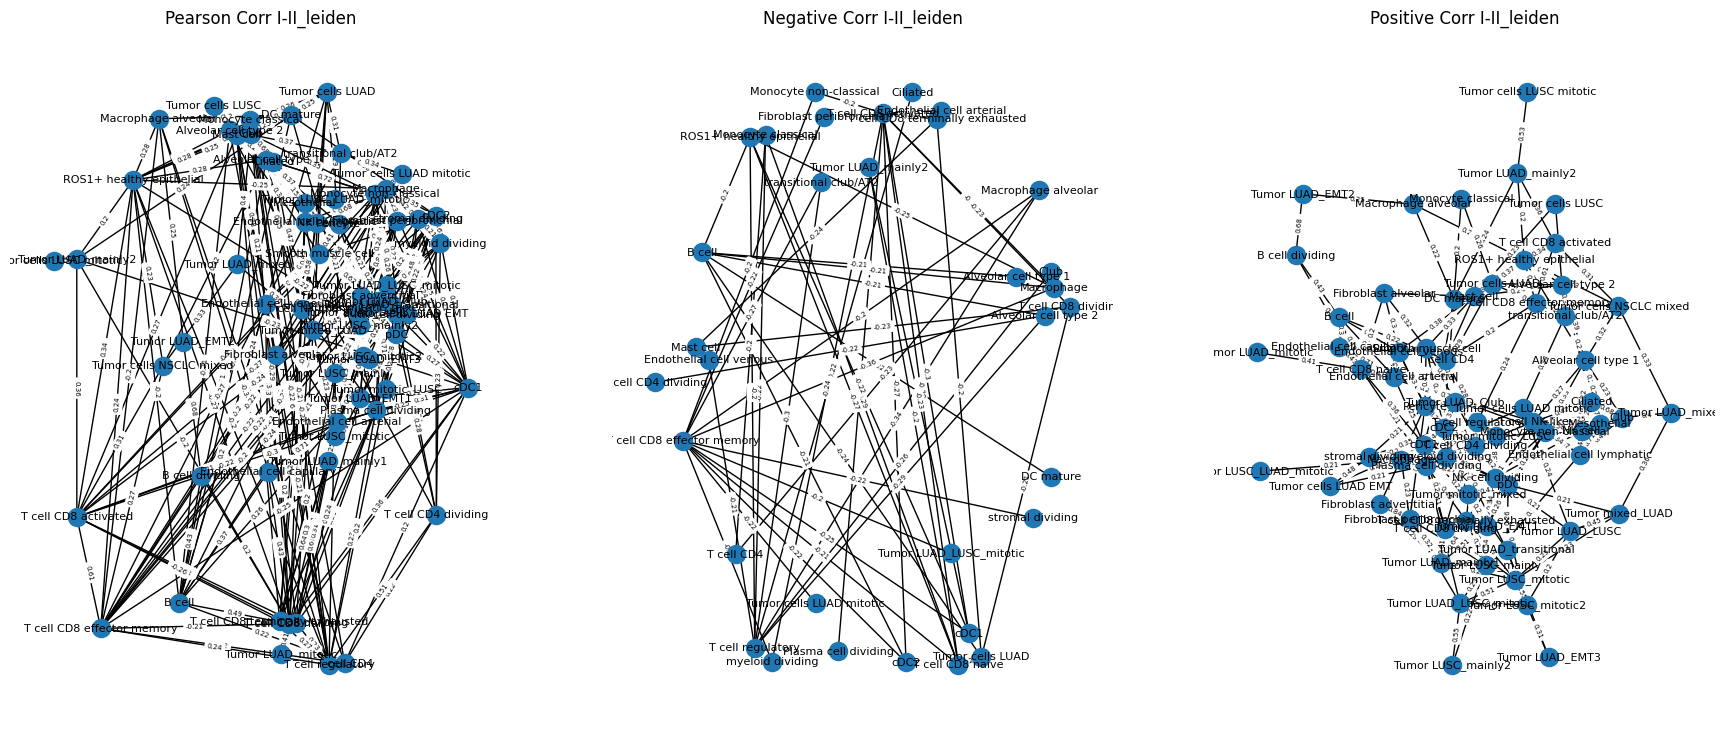

In [123]:
G_I, G_I_neg, G_I_pos, corr_types_I, corr_types1_I, corr_plus1_normI = plot_corr_networks(time, corr_threshold=thres, p_threshold=0.05,)

In [28]:
non_linear_I, non_signif_I, G_MI_I =  get_nonlinear_edges(time, G_I)

Total MIII edges: 193
Non linear edges # for I-II_leiden with thres=0.2: 130


Export the graph with pos and negative annotated

In [152]:
add_pearson_edges(G_MI_I, time, 0.1, export=True)

### Abundance Heatmap

/usr/local/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


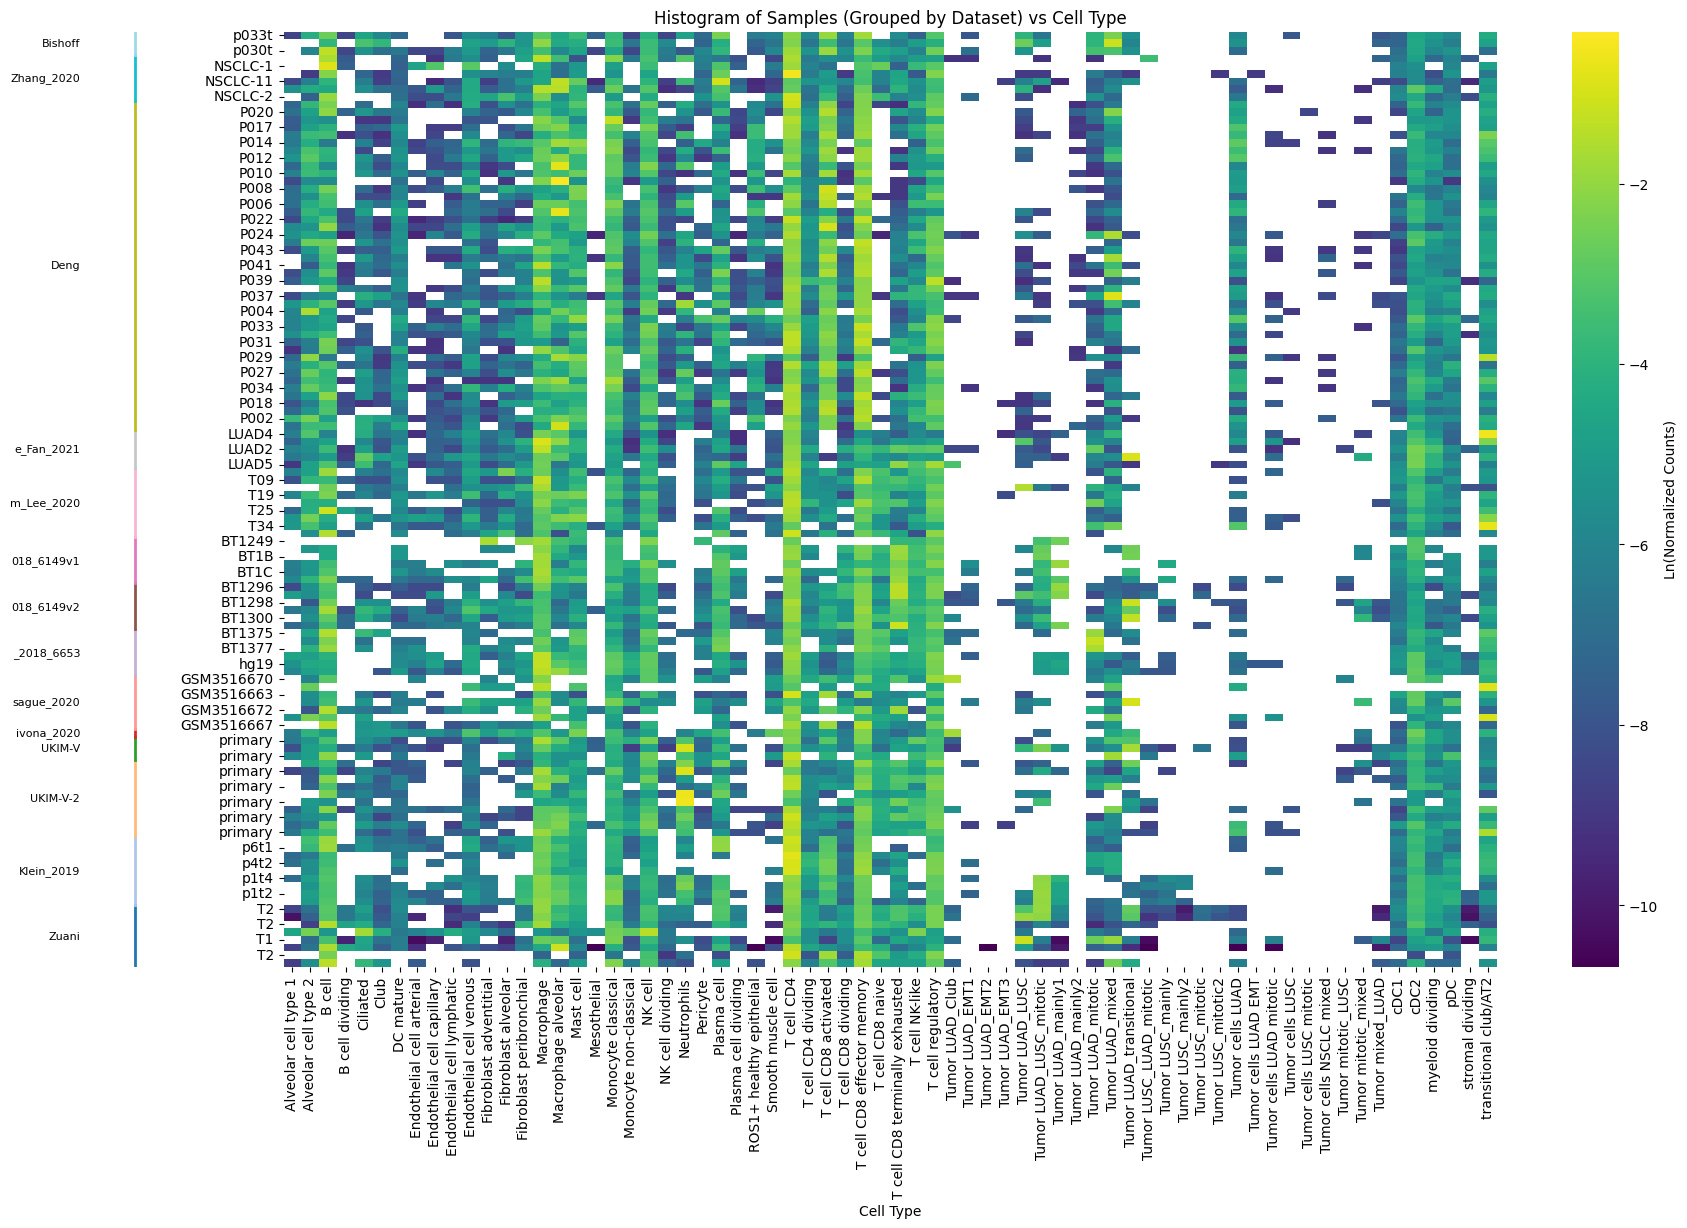

In [124]:
plot_abundance_heatmap(corr_types_I)

### Scatter plots

Why is Monocyte vs Mast high MI and not Pearson. Maybe it is because the trend is in log relationship?

That is because in log coordinates there is a linear relationship

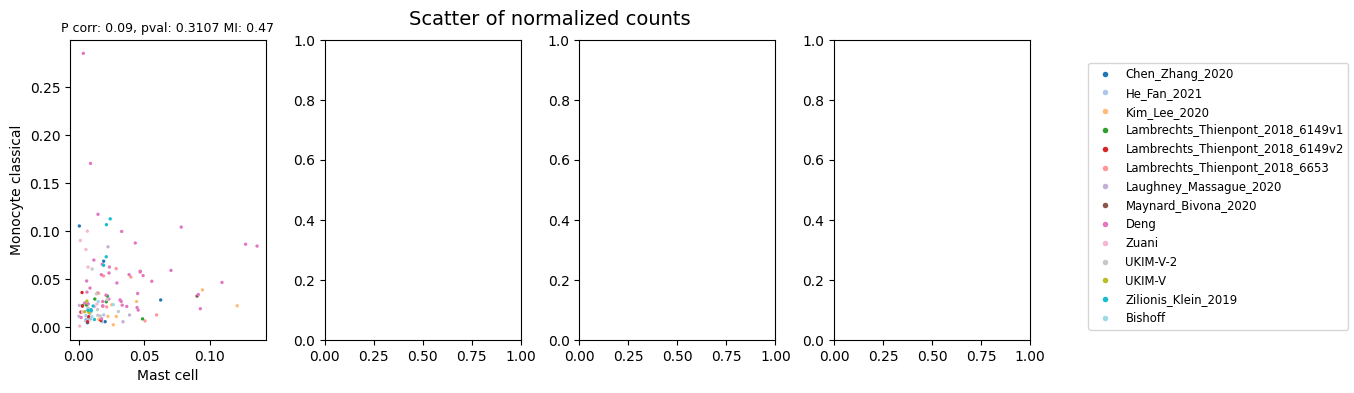

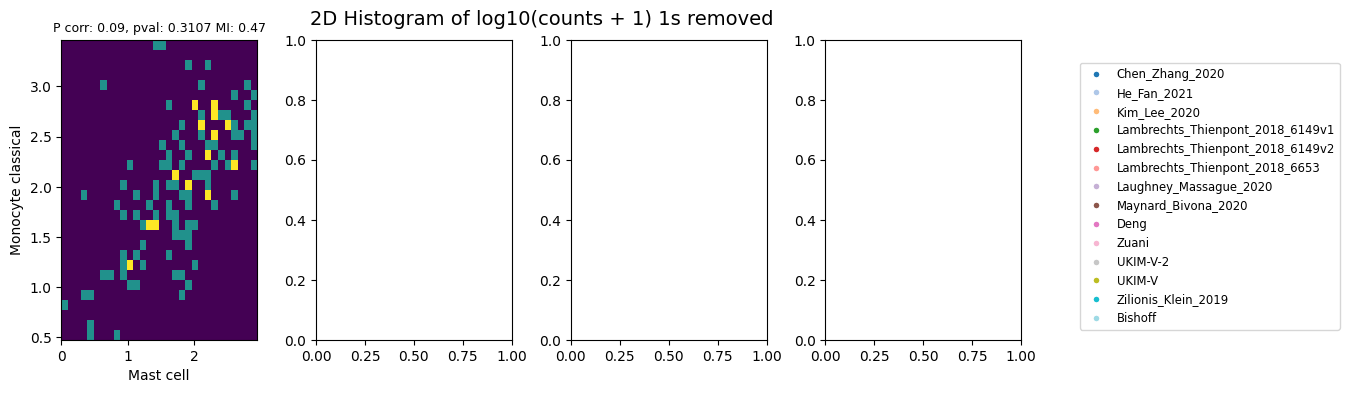

In [198]:
# To check ine in particular
sample_scatter(time,  [('Mast cell', 'Monocyte classical'),], corr_types_I, G_MI_I, indices=[0])
sample_scatter(time,  [('Mast cell', 'Monocyte classical'),], corr_types_I, G_MI_I, indices=[0], corr_counts=corr_types1_I)

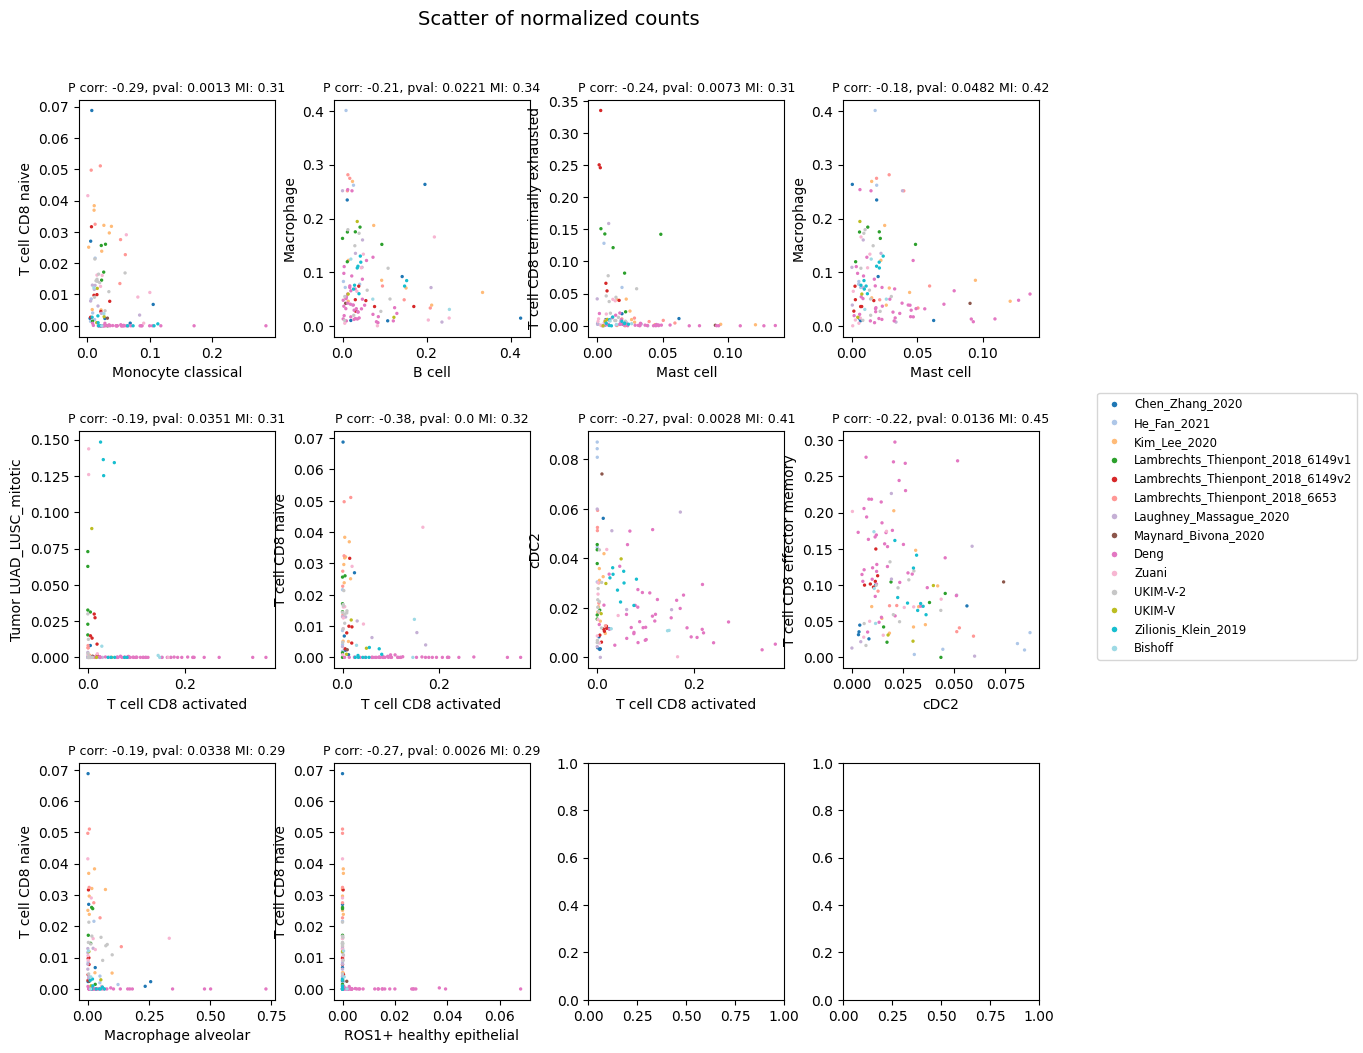

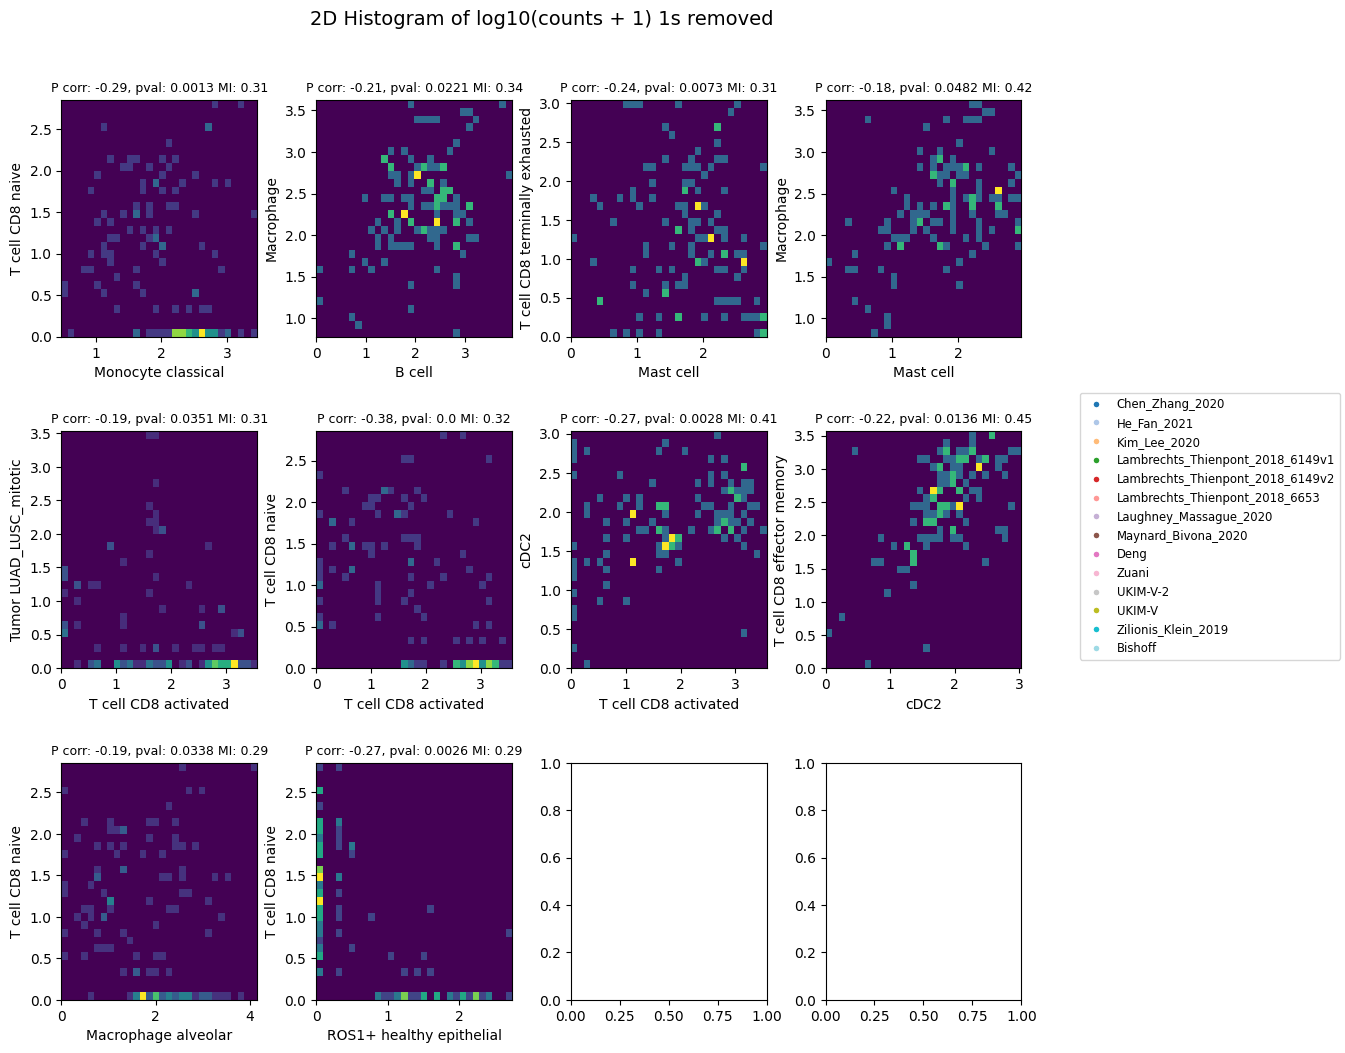

In [210]:
neg_edges = [
        (u, v)
        for u, v, data in G_MI_I.edges(data=True)
        if data.get("sign", "") == "negative_significant"
    ]

sample_scatter(time,  neg_edges, corr_types_I, G_MI_I, indices=range(len(neg_edges)))
sample_scatter(time,  neg_edges, corr_types_I, G_MI_I, indices=range(len(neg_edges)), corr_plus1_norm=corr_plus1_normI)
sample_scatter(time,  neg_edges, corr_types_I, G_MI_I, indices=range(len(neg_edges)), corr_counts=corr_types1_I)

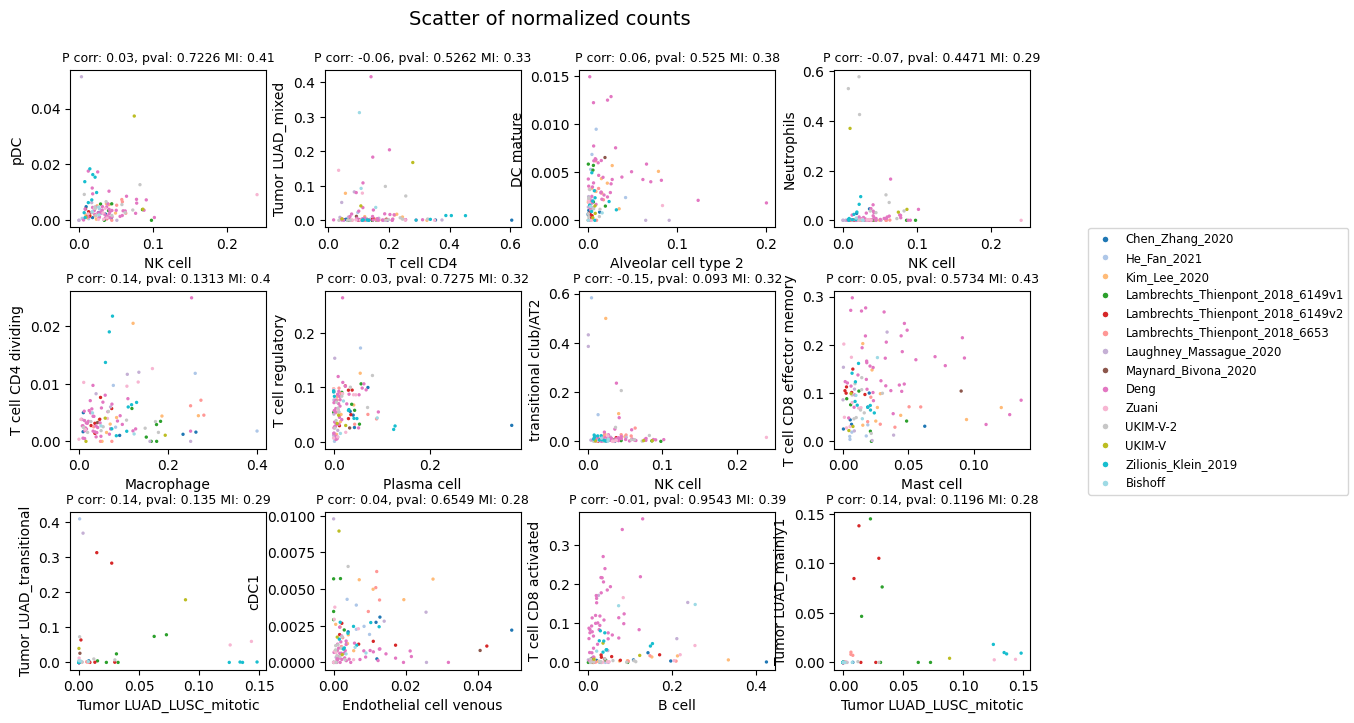

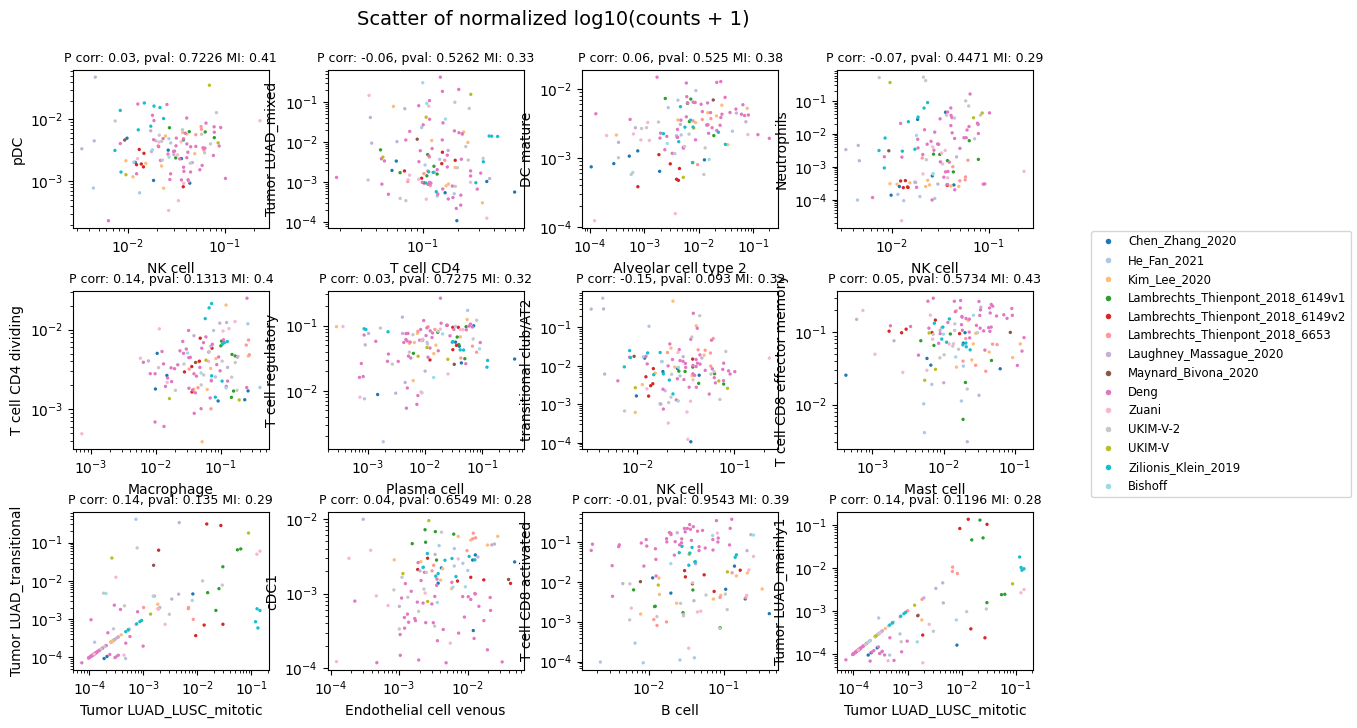

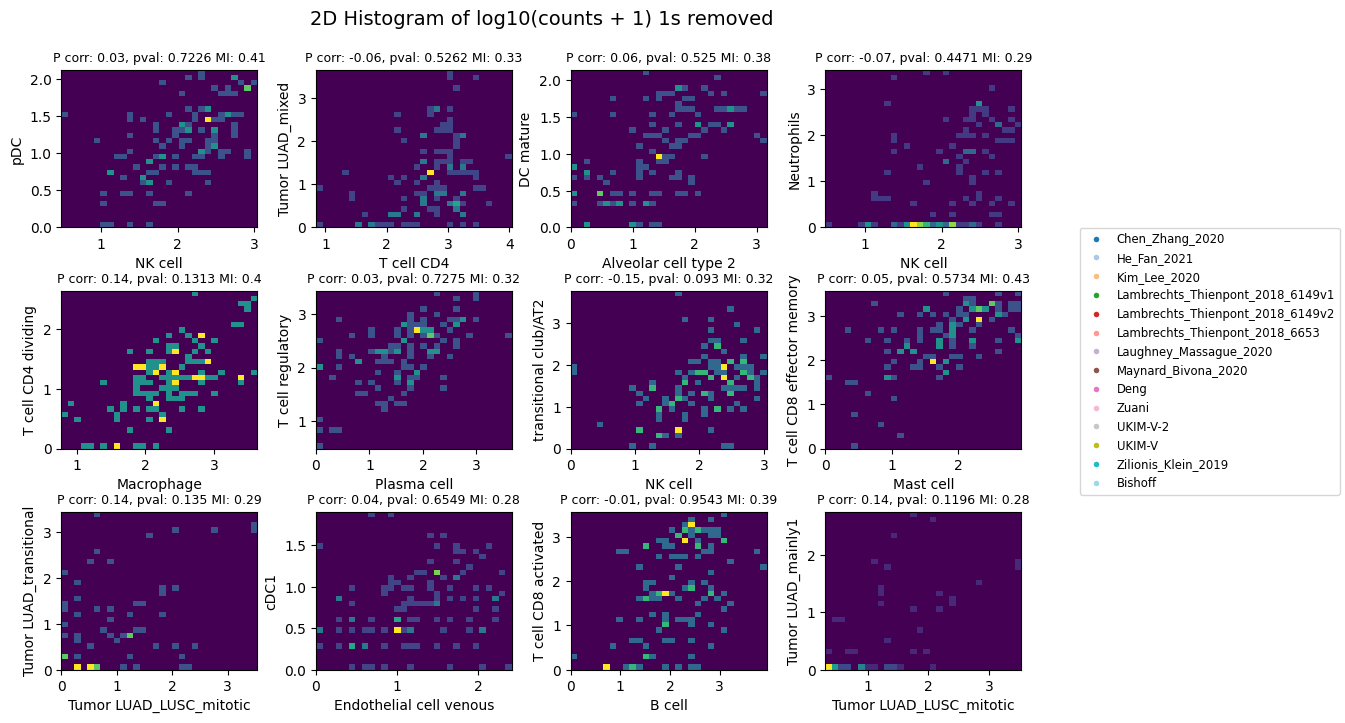

In [183]:
# sample_scatter(time, non_linear_I, corr_types_I, G_MI_I, indices=list(range(0,6)), log=False)
time = 'I-II_leiden'
inds = np.random.choice(len(non_linear_I), 12, replace=False)
sample_scatter(time, non_linear_I, corr_types_I, G_MI_I, indices=inds)
sample_scatter(time, non_linear_I, corr_types_I, G_MI_I, indices=inds, corr_plus1_norm=corr_plus1_normI)
sample_scatter(time, non_linear_I, corr_types_I, G_MI_I, indices=inds, corr_counts=corr_types1_I)

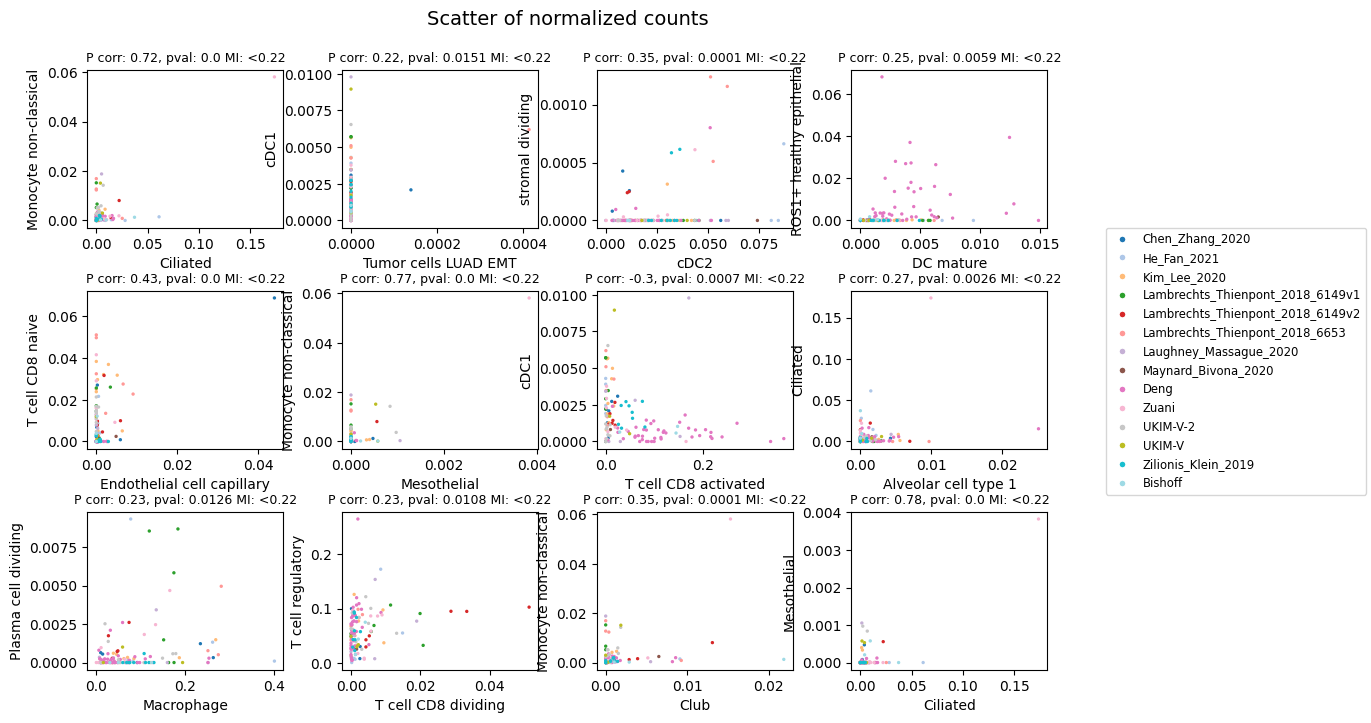

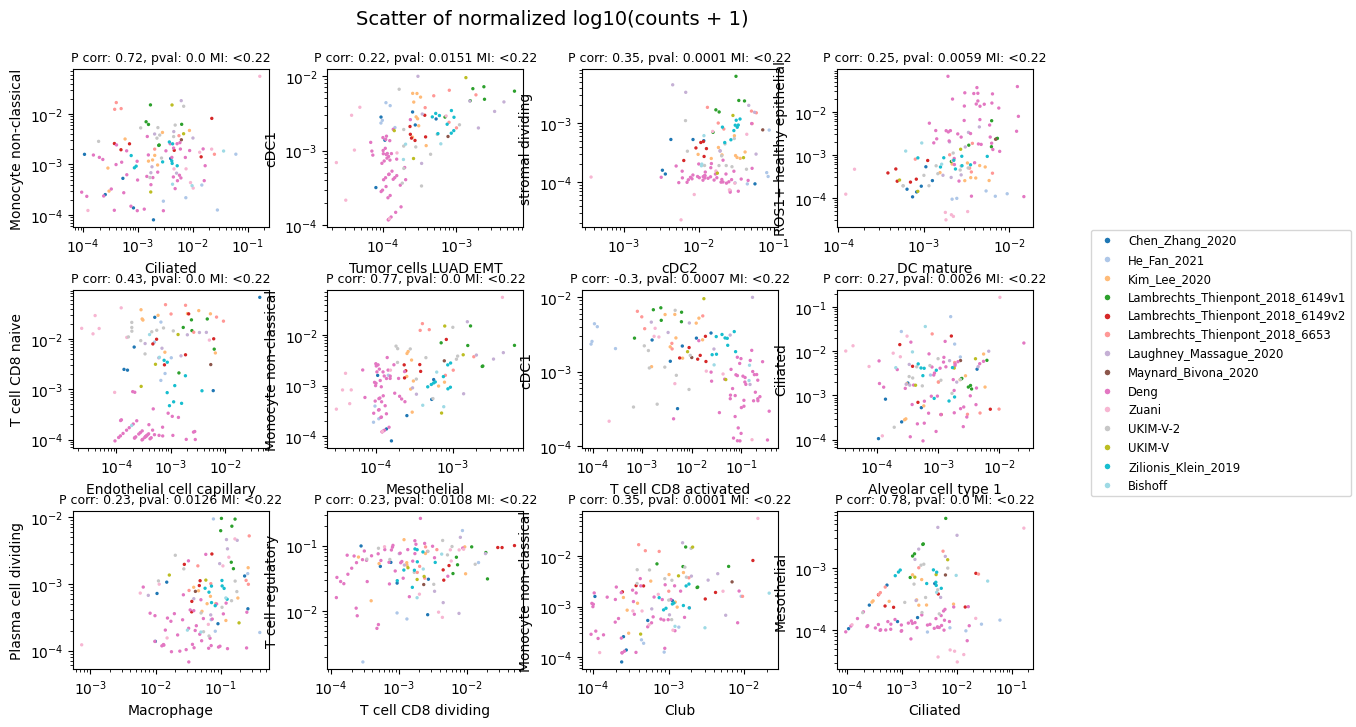

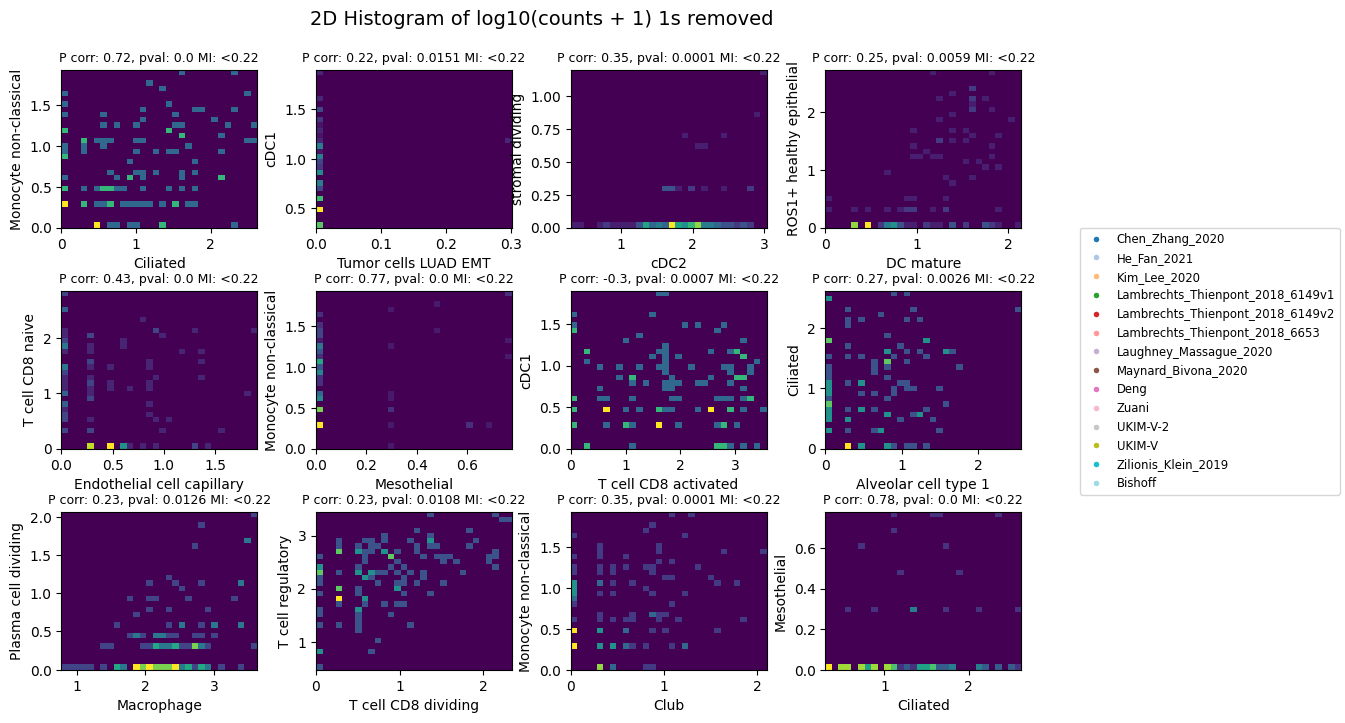

In [184]:
time = 'I-II_leiden'
inds = np.random.choice(len(non_signif_I), 12, replace=False)
sample_scatter(time, non_signif_I, corr_types_I, G_MI_I, indices=inds)
sample_scatter(time, non_signif_I, corr_types_I, G_MI_I, indices=inds, corr_plus1_norm=corr_plus1_normI)
sample_scatter(time, non_signif_I, corr_types_I, G_MI_I, indices=inds, corr_counts=corr_types1_I)

## III-IV

### Nets and calc

In [172]:
time = 'III-IV_leiden'

Size of Corr_types: (111, 67)
Size of Corr_types +1: (111, 67)
Size of Corr_types +1: (111, 69)


/tmp/ipykernel_190648/1050142223.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  zeros_per_dataset = samp_type_with_dataset.groupby('dataset').apply(lambda x: (x.drop(['dataset',sample_key], axis=1) != 0).sum())


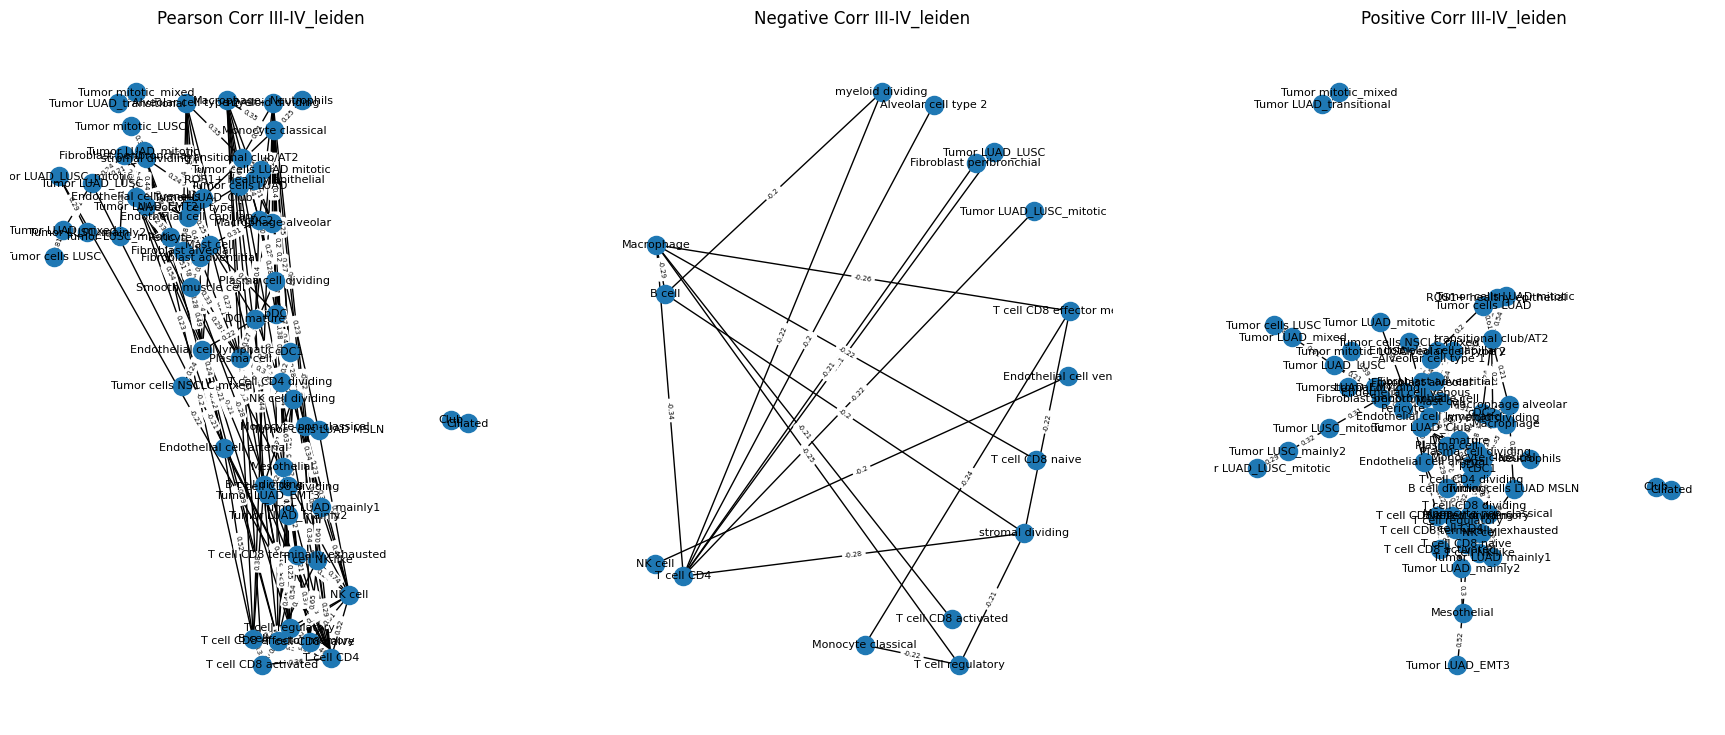

In [126]:
G_III, G_III_neg, G_III_pos, corr_types_III, corr_types1_III, corr_logsIII = plot_corr_networks(time, corr_threshold=thres, p_threshold=0.05,)

In [14]:
non_linear_III, non_signif_III, G_MI_III =  get_nonlinear_edges(time, G_III)

Total MIII edges: 162
Non linear edges # for III-IV_leiden with thres=0.2: 75


Export the graph with pos and negative annotated

In [158]:
add_pearson_edges(G_MI_III, time, 0.1, export=True)

### Abundance Heatmap

/usr/local/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


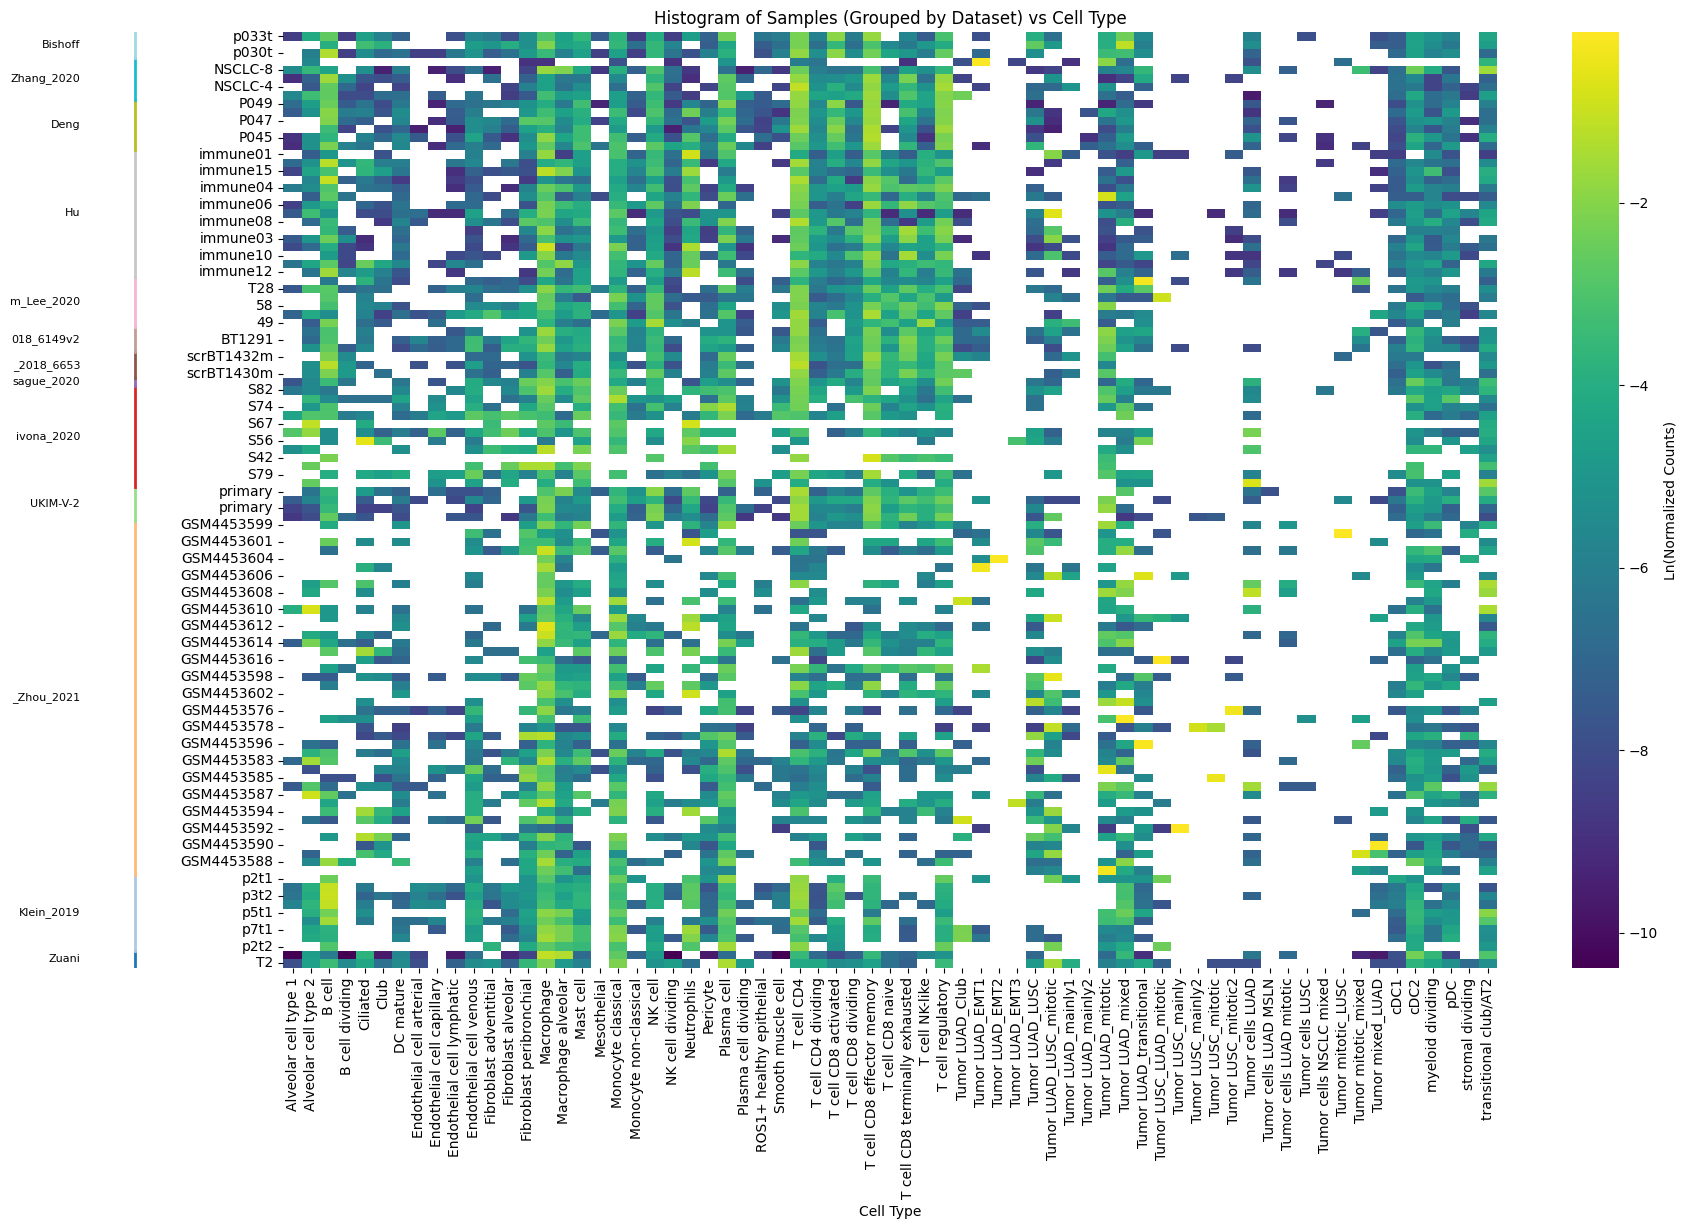

In [127]:
plot_abundance_heatmap(corr_types_III)

### Scatter plots

pDC andT cell CD8 effector memory have veryh high MI 0.43 but super low corr and very high pval, when looking at the scatter plot it looks like there are some isolated trends, maybe they are correlated with the dataset.

We can see from the singular plots below that in log scale there is a general upward tren but in low values there is also a downward trend.

Endothelial cell venous Macrophage has an up down trend
 

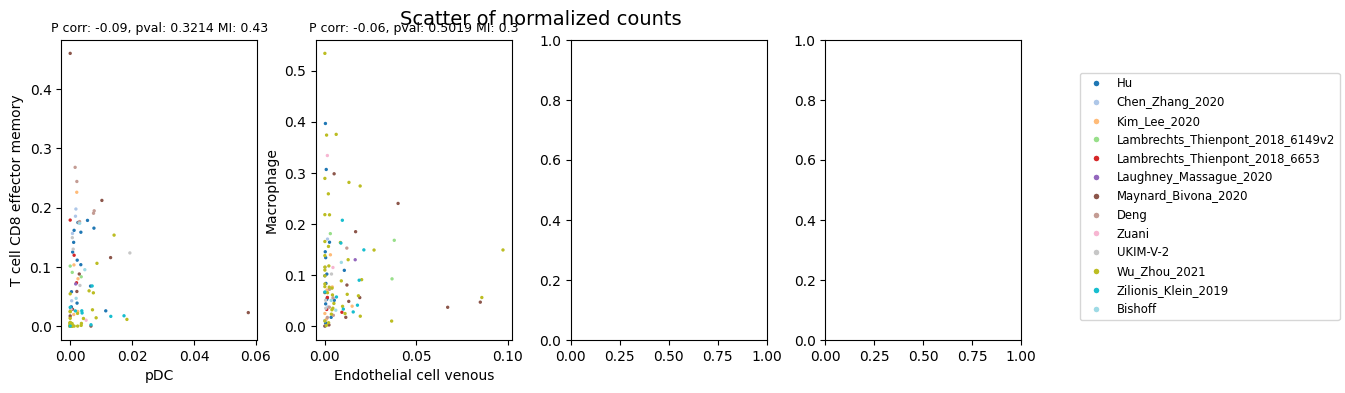

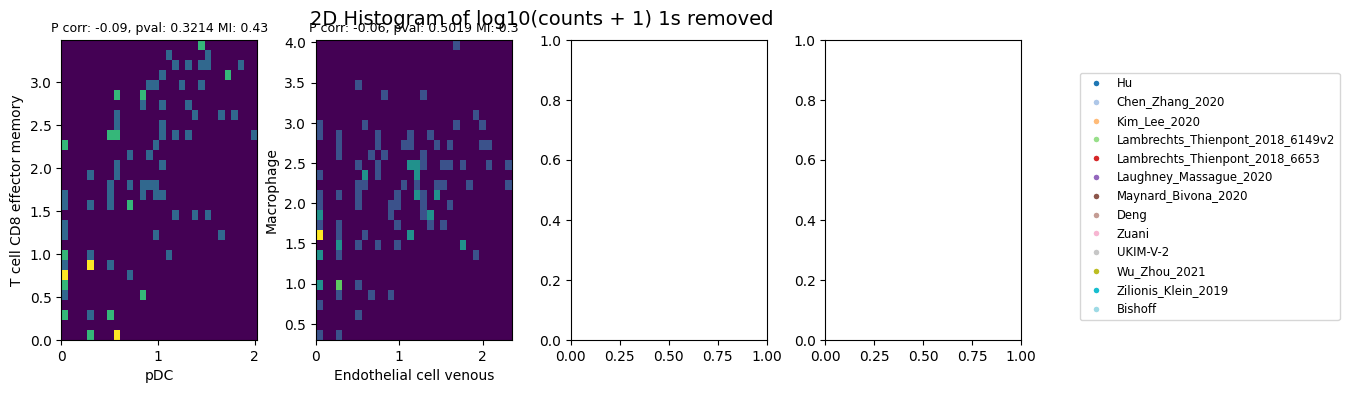

In [200]:
# To check ine in particular
pairs = [('pDC', 'T cell CD8 effector memory'),('Endothelial cell venous', 'Macrophage')]
inds = [0,1]
sample_scatter(time,  pairs, corr_types_III, G_MI_III, indices=inds)
sample_scatter(time,  pairs, corr_types_III, G_MI_III, indices=inds, corr_counts=corr_types1_III)

We can see that the negative correlation are always because one dataset has almost none of one type of cell and high values of another. 

In the log transformed plots this is not visible

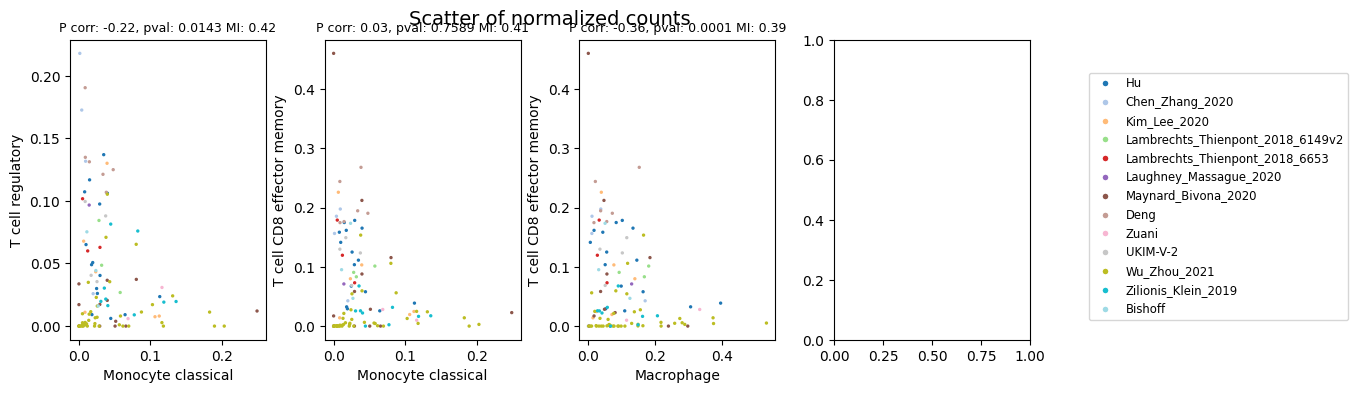

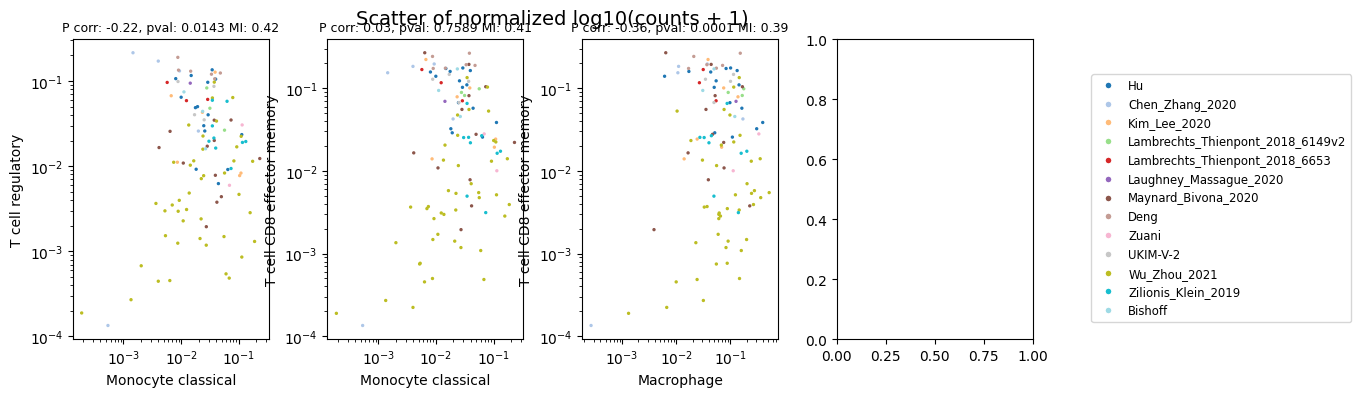

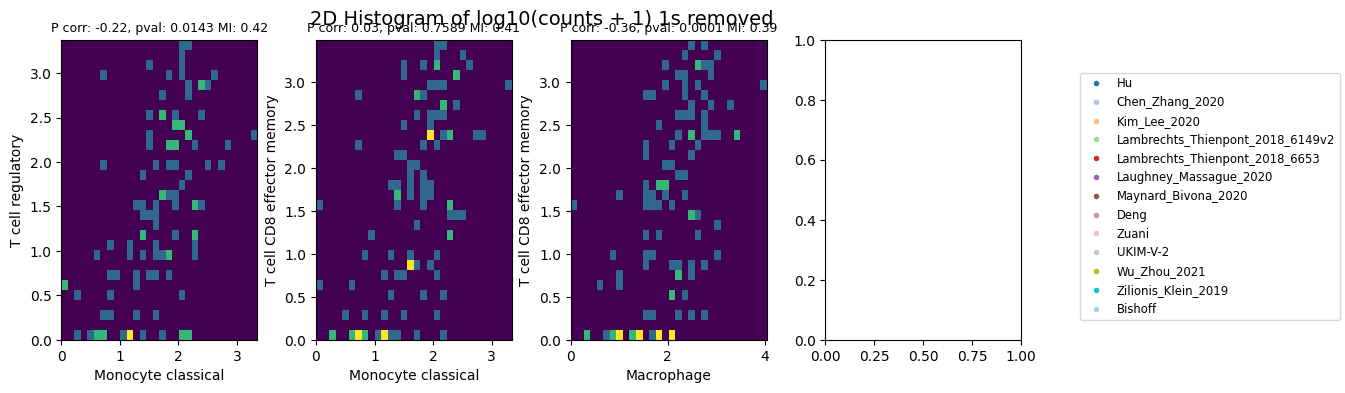

In [212]:
neg_edges = [
        (u, v)
        for u, v, data in G_MI_III.edges(data=True)
        if data.get("sign", "") == "negative_significant"
    ]

sample_scatter(time,  neg_edges, corr_types_III, G_MI_III, indices=range(len(neg_edges)))

sample_scatter(time,  neg_edges, corr_types_III, G_MI_III, indices=range(len(neg_edges)), corr_plus1_norm=corr_logsIII)
sample_scatter(time,  neg_edges, corr_types_III, G_MI_III, indices=range(len(neg_edges)), corr_counts=corr_types1_III)

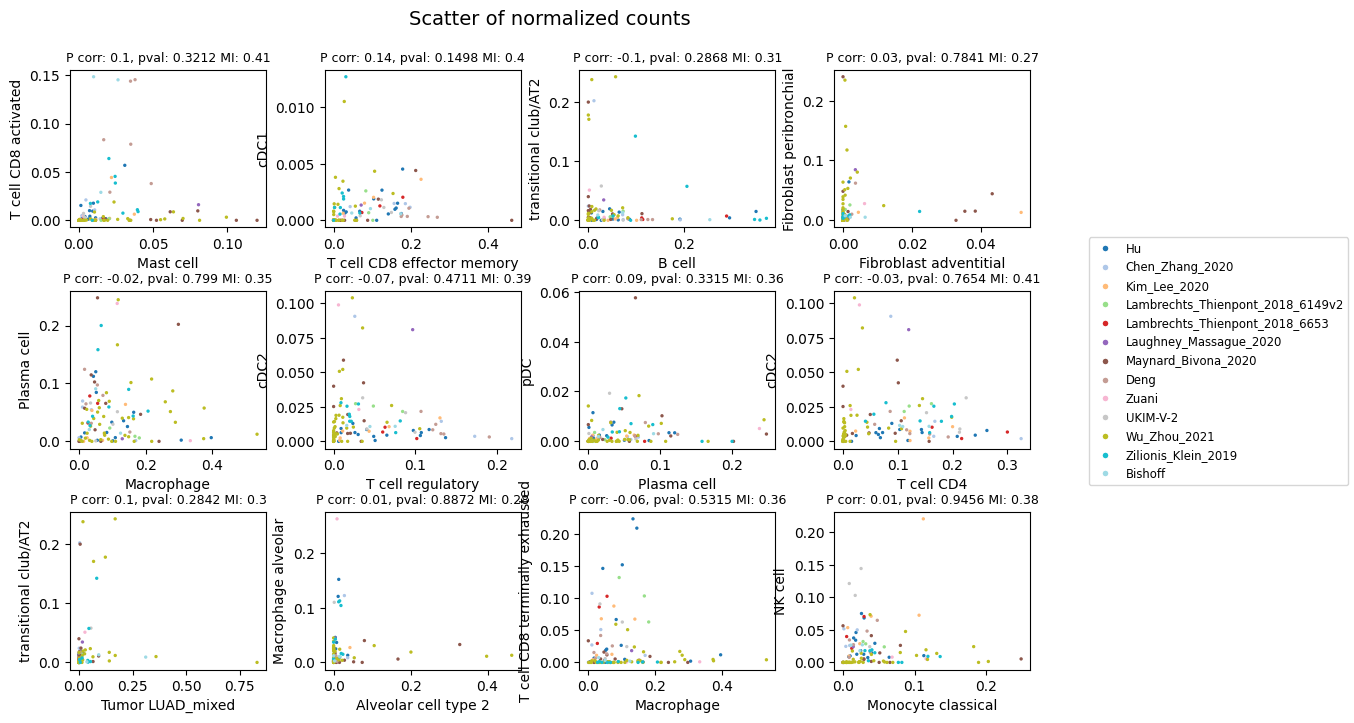

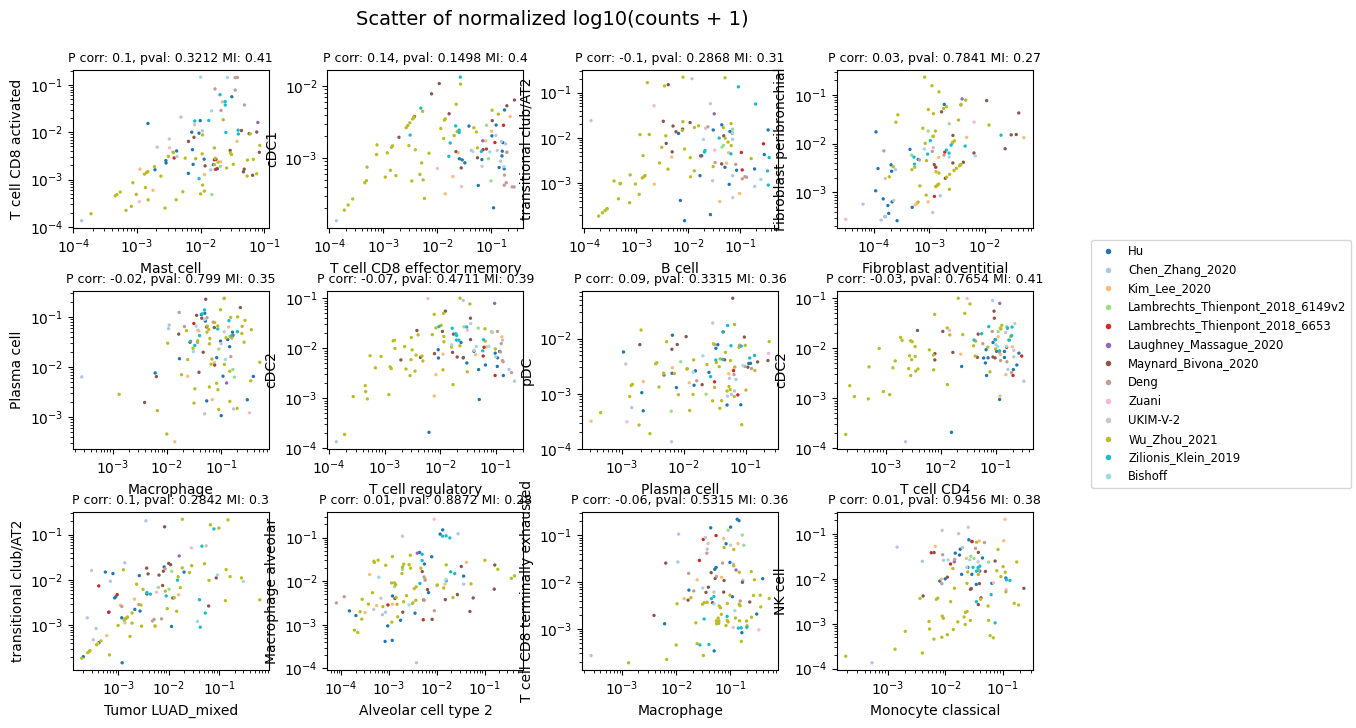

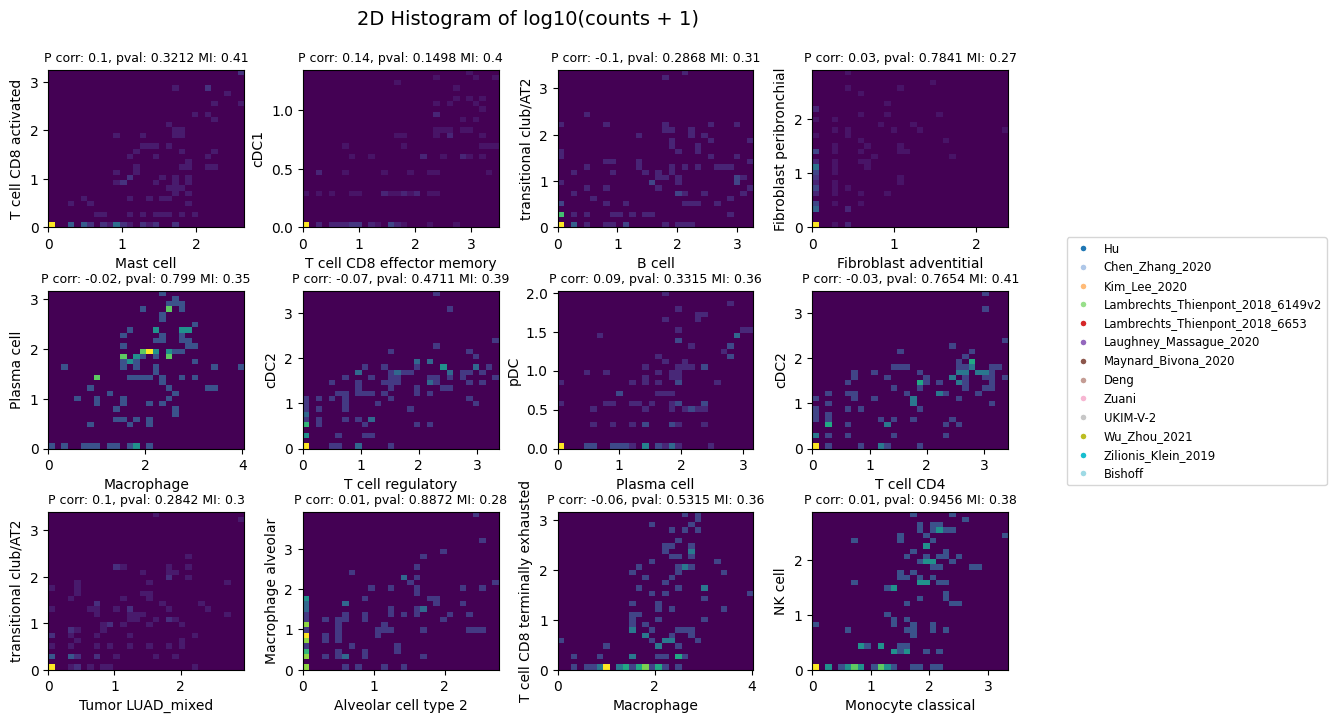

In [173]:
time = 'III-IV_leiden'
inds = np.random.choice(len(non_linear_III), 12, replace=False)
sample_scatter(time, non_linear_III, corr_types_III, G_MI_III, indices=inds)
sample_scatter(time, non_linear_III, corr_types_III, G_MI_III, indices=inds, corr_plus1_norm=corr_logsIII)
sample_scatter(time, non_linear_III, corr_types_III, G_MI_III, indices=inds, corr_counts=corr_types1_III)

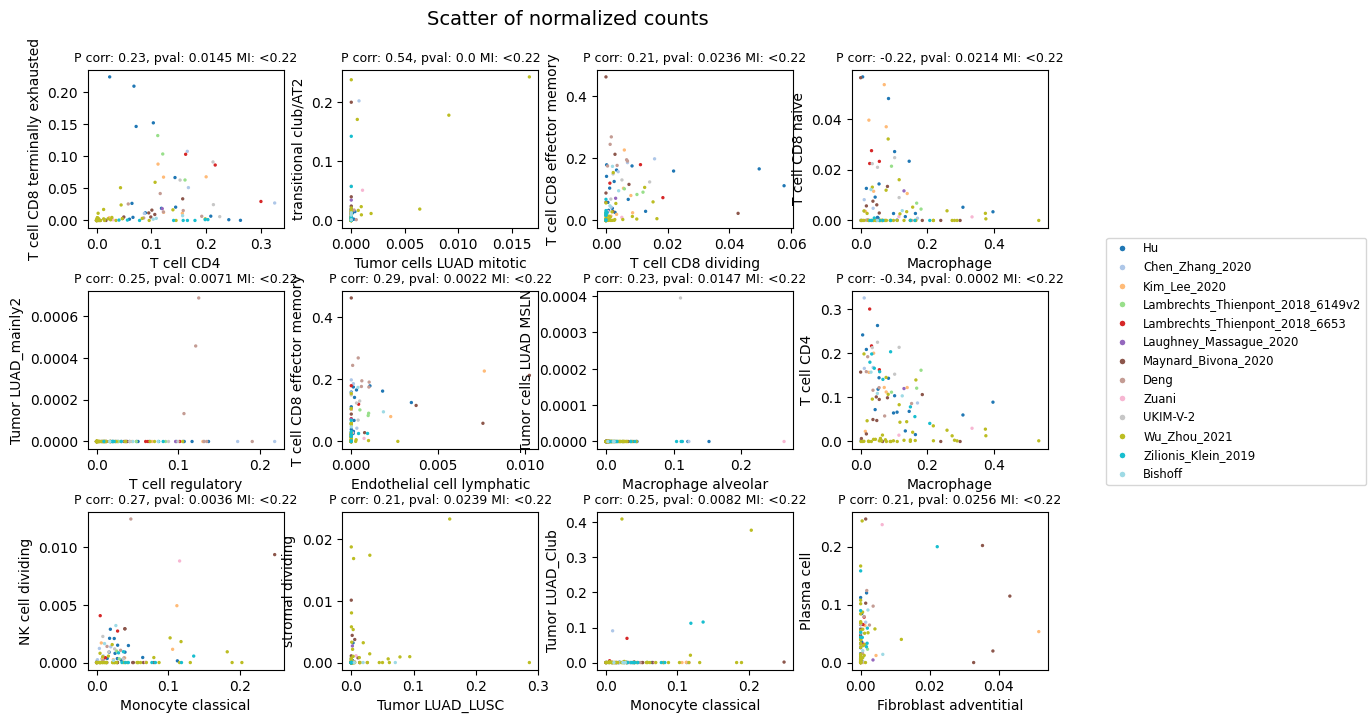

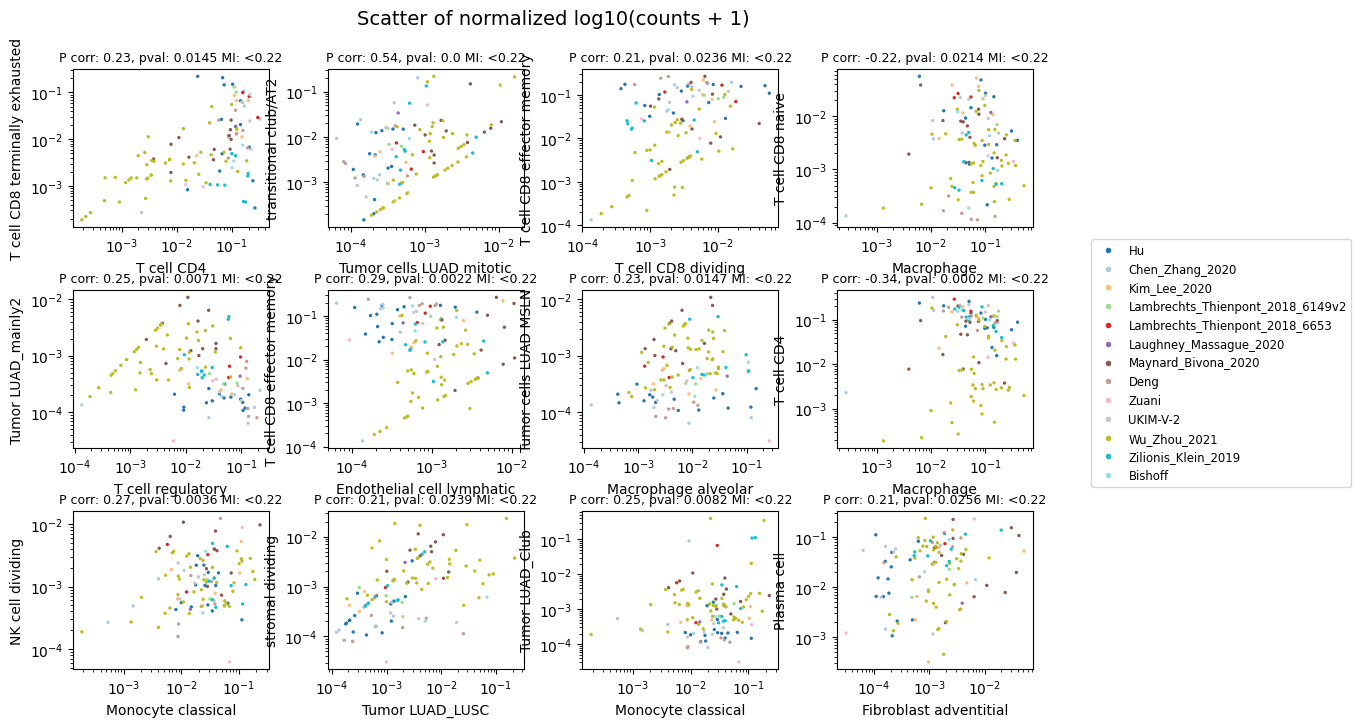

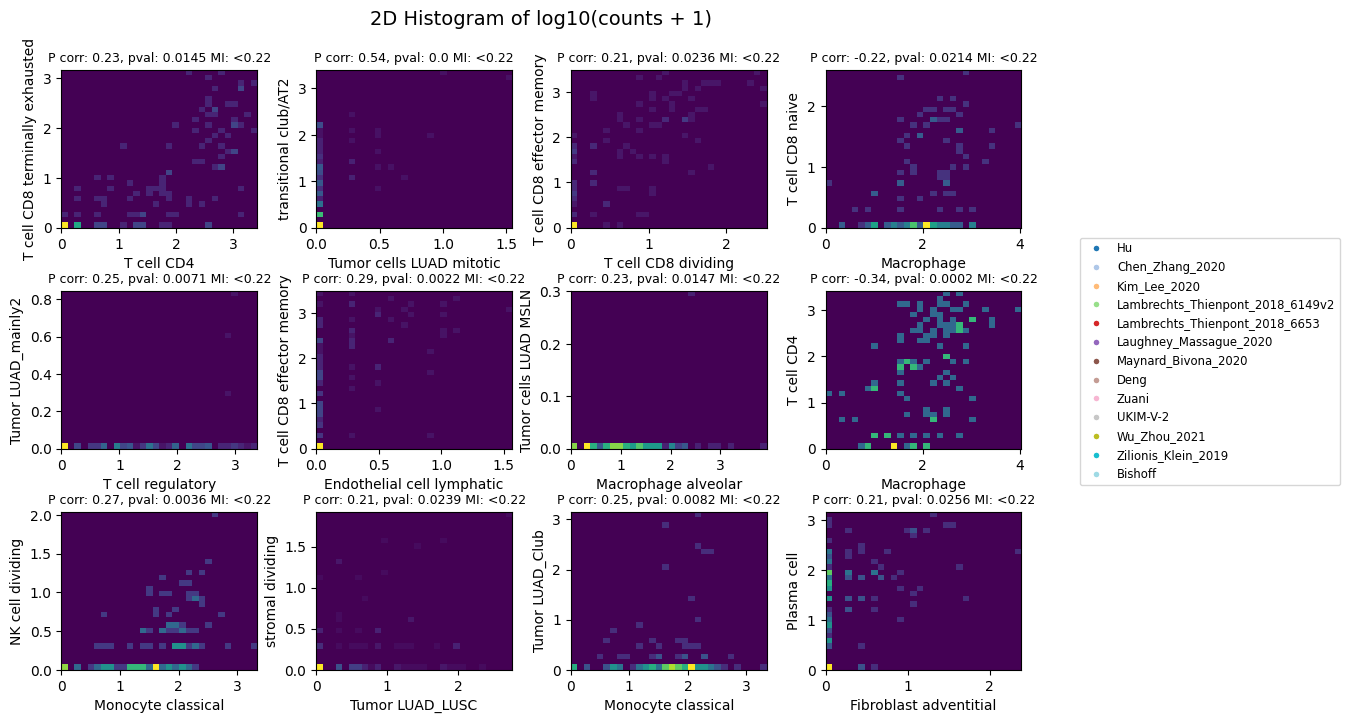

In [174]:
time = 'III-IV_leiden'
inds = np.random.choice(len(non_signif_III), 12, replace=False)
sample_scatter(time, non_signif_III, corr_types_III, G_MI_III, indices=inds)
sample_scatter(time, non_signif_III, corr_types_III, G_MI_III, indices=inds, corr_plus1_norm=corr_logsIII)
sample_scatter(time, non_signif_III, corr_types_III, G_MI_III, indices=inds, corr_counts=corr_types1_III)

## Conditional MI

Just a quick excerpt to visualize how conditional MI raises for vars that depend on a covariate.

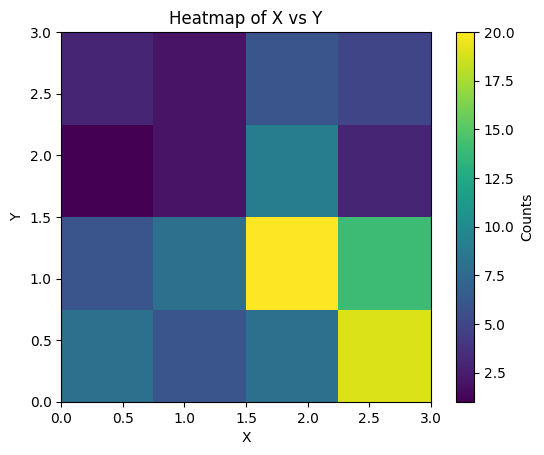

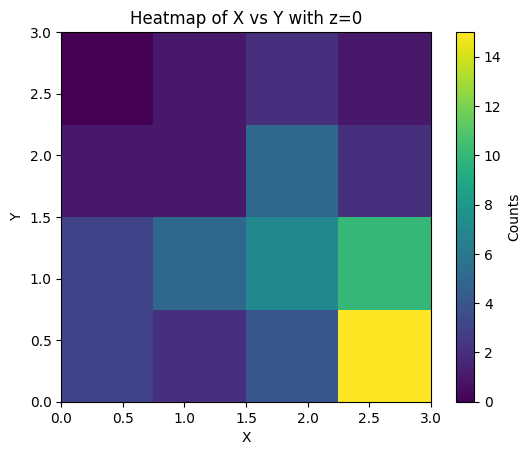

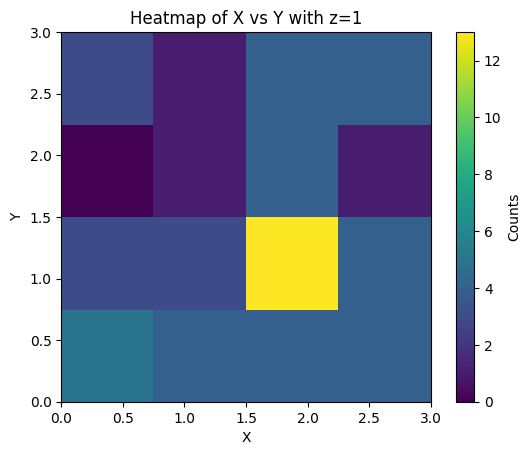

Conditional Mutual Information I(X; Y | Z): 0.0984
Mutual Information together I(X; Y): 0.0463
Mutual Information z=1 I(X1; Y1): 0.0825
Mutual Information z=0 I(X0; Y0): 0.0766


In [31]:
import numpy as np
from sklearn.metrics import mutual_info_score
import matplotlib.pyplot as plt

# Function to compute mutual information between two discrete variables
def mutual_information(x, y):
    return mutual_info_score(x, y)

# Function to compute conditional mutual information I(X;Y|Z)
def conditional_mutual_information_pandas(x, y, z):
    df = pd.DataFrame({'x': x, 'y': y, 'z': z})
    n = len(df)

    # Compute joint probabilities
    p_xyz = df.groupby(['x', 'y', 'z']).size() / n
    p_xz = df.groupby(['x', 'z']).size() / n
    p_yz = df.groupby(['y', 'z']).size() / n
    p_z = df.groupby(['z']).size() / n

    cmi = 0.0

    # Iterate over all combinations
    for (x_val, y_val, z_val), p_xyzi in p_xyz.items():
        p_xzi = p_xz[(x_val, z_val)]
        p_yzi = p_yz[(y_val, z_val)]
        p_zi = p_z[z_val]

        # Compute contribution to CMI
        cmi += p_xyzi * np.log(p_xyzi * p_zi / (p_xzi * p_yzi))

    return cmi

# Example data
# Assume x, y, z are discrete variables encoded as integer arrays
# For demonstration, we'll generate sample data
np.random.seed(42)

# Sample size
n = 120

# Confounding variable Z
z = np.random.choice([0, 1], size=n, p=[0.5, 0.5])

z_1 = [x for x in z if x==1]
z_0 = [x for x in z if x==0]

# Variables X and Y influenced by Z
x_1 = np.random.choice([0, 1, 2, 3], size=len(z_1), p=[0.2, 0.1, 0.4, 0.3])
y_1 = np.random.choice([0, 1, 2, 3], size=len(z_1), p=[0.3, 0.4, 0.1, 0.2])

x_0 = np.random.choice([0, 1, 2, 3], size=len(z_0), p=[0.1, 0.2, 0.3, 0.4])
y_0 = np.random.choice([0, 1, 2, 3], size=len(z_0), p=[0.4, 0.3, 0.2, 0.1])

x = np.concatenate((x_0, x_1))
y = np.concatenate((y_0, y_1))

# Scatter plot of X vs Y
# Create a heatmap of X vs Y
heatmap, xedges, yedges = np.histogram2d(x, y, bins=(4, 4))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.imshow(heatmap.T, extent=extent, origin='lower', cmap='viridis')
plt.colorbar(label='Counts')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Heatmap of X vs Y')
plt.show()

heatmap, xedges, yedges = np.histogram2d(x_0, y_0, bins=(4, 4))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.imshow(heatmap.T, extent=extent, origin='lower', cmap='viridis')
plt.colorbar(label='Counts')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Heatmap of X vs Y with z=0')
plt.show()

heatmap, xedges, yedges = np.histogram2d(x_1, y_1, bins=(4, 4))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.imshow(heatmap.T, extent=extent, origin='lower', cmap='viridis')
plt.colorbar(label='Counts')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Heatmap of X vs Y with z=1')
plt.show()

# Compute conditional mutual information I(X; Y | Z)
cmi_xy_z = conditional_mutual_information_pandas(x, y, z)
mi_x_y_z = mutual_information(x, y )
mi_x1_y1 = mutual_information(x_1, y_1)
mi_x0_y0 = mutual_information(x_0, y_0)

print(f"Conditional Mutual Information I(X; Y | Z): {cmi_xy_z:.4f}")
print(f"Mutual Information together I(X; Y): {mi_x_y_z:.4f}")
print(f"Mutual Information z=1 I(X1; Y1): {mi_x1_y1:.4f}")
print(f"Mutual Information z=0 I(X0; Y0): {mi_x0_y0:.4f}")